In [18]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
from pylab import *
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import bipartite
import random as rd
from collections import Counter
import pylab 
import scipy.stats as stats
import warnings
import matplotlib.animation as animation
import os


warnings.filterwarnings('ignore')


In [19]:
#Function for drawing radial graphs in NetworkX library
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [20]:
#Counting the number of clusters and composition of cluster (cells per cluster)
def module_counter():
    global g
    cluster_counter=0
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==0):
            cluster_counter=cluster_counter+1
            for n in g.nodes():
                if(n.endswith(e[1][1:])):
                    g.nodes[n]['clust']=str(cluster_counter)

In [21]:
#Calculation of Kullback-Leibler Divergence between the experimental and model derived distribution
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [22]:
#Count the distribution of number of cells per cluster
def count_freq(g):
    clust_information=[]
    for n in g.nodes():
        clust_information.append(g.nodes[n]['clust'])
    a=Counter(clust_information)
    freq=list(a.values())
    return freq

In [23]:
def graph_snap(t,sim_time):
    for n in g.nodes():
        g.nodes[n]['snap_time']=int(str(n)[1])
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==1):
            g.edges[e[0],e[1]]['snap_time']=int(e[1][1])-1
        else:
            g.edges[e[0],e[1]]['snap_time']=sim_time

In [24]:
##This is model 1A in which there is only link breaking without any steric forces
def break_cluster(t,max_node):
    global g
    cluster_counter=0
    degree_list=[]
    
    for e in g.edges():
        if(t>=g.edges[e[0],e[1]]['t_break']):
            g.edges[e[0],e[1]]['break']=0
        

In [25]:
def grow(t,mbt):
    global g
    nextg=g.copy()
    for n in g.nodes():
        new_node='Y'+str(t)+'_'+str(n)[1:] #Naming daughter cells to track lineage information
        nextg.add_edge(str(n),new_node) #Growth
        nextg.nodes[new_node]['clust']=nextg.nodes[str(n)]['clust'] #Inherit the cluster information
        nextg.edges[str(n),new_node]['break']=1
        nextg.edges[str(n),new_node]['t_break']=t+np.random.exponential(scale=mbt)
    g=nextg



In [26]:
def init_system():
    global g
    g=nx.Graph() #Initialization 
    g.add_node('Y0') #Mother yeast cell 
    g.nodes['Y0']['clust']='0'
    nextg=g.copy()

In [27]:
#Main function to call other functions associated with dissociation of the cluster, counting of cells per custer
def clust_form_and_break(sim_time,max_node,mbt,dt):
    global g
    
    init_system()
    
    for t in range(sim_time):
        if(int(t%dt)==0): 
            grow(t,mbt)
        break_cluster(t,max_node)
        graph_snap(t,sim_time)
    
    module_counter()
    
    return g

## Cluster Size Distribution

In [12]:
%%time
%matplotlib inline
sim_time=int(input('Enter Simulation Time'))
kissing_no=int(input('Enter Kissing Number'))
mean_breaking_time=int(input('Enter Mean Breaking Time'))
doubling_time=float(input('Enter Doubling Time'))
repeats=int(input('Enter number of repeats'))

rad=[]

for i in range(repeats):
    g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time)
    rad.append(np.array(count_freq(g)).mean())

mean=np.mean(rad)
std=np.std(rad)/np.power(repeats,0.5)
# plt.plot([mean,mean],[0,0.6])
print('\n')
print('Number of cells per cluster:', np.round(mean,3),u'\u00B1',np.round(std,3))
print('\n')

plt.figure(figsize=(6,6))
sns.distplot(np.array(count_freq(g)),hist=False,color='blue',bins=5)
plt.xlabel('Cells per cluster',fontsize=16)
plt.ylabel('Density',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


KeyboardInterrupt: Interrupted by user

# Model vs Experiment

### Data BUD4

In [28]:
cd /Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Data/ePN002/BUD4_Repeat_2/counts_2/

/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Data/ePN002/BUD4_Repeat_2/counts_2


In [29]:
files=sorted(os.listdir())
counts=[]
count_data=pd.DataFrame()

for f in files:
    if('BUD4' in f):
        df=pd.read_csv(f)['cell_counts']
        count_data[f[7:f.index('.c')]]=df

CPU times: user 2.24 s, sys: 134 ms, total: 2.37 s
Wall time: 1.85 s


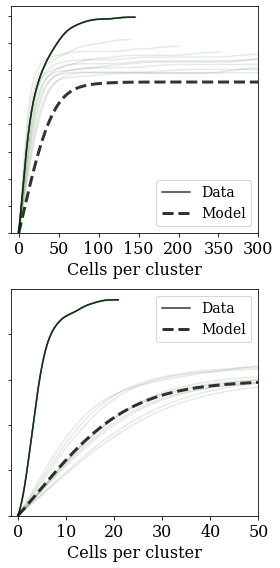

In [30]:
%%time
%matplotlib inline

kn=[8,5]
gr=[3.,3.]
be=['0','7.5']
xlim=[400,50]
bins=[50,50]
plt.rc('font',family='serif')
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(4,8))
t=['BUD4OFF','BUD4ON']

# np.random.seed(50)
for i in range(2):
    sim_time=int(gr[i]*10)
    kissing_no=kn[i]
    mean_breaking_time=50
    doubling_time=gr[i]
    repeats=10
    g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time)
    sns.kdeplot(count_data[be[i]],color=(0,0.0,0.0,0.8),clip=(0,xlim[i]),ax=ax[i],cumulative=True)
    sns.kdeplot(np.array(count_freq(g)),color=(0,0.0,0.0,0.8),clip=(0,xlim[i]),ax=ax[i],linestyle='--',linewidth=3,cumulative=True)
    ax[i].set_yticklabels([])
    ax[i].set_ylabel('')
    ax[0].legend(['Data','Model'],fontsize=14)
    ax[1].legend(['Data','Model'],fontsize=14)

    for j in range(10):
        sim_time=int(gr[i]*10)
        kissing_no=kn[i]
        mean_breaking_time=50
        doubling_time=gr[i]
        repeats=10
        g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time)
        sns.kdeplot(count_data[be[i]],color=(0,0.2,0.0,0.1),clip=(0,xlim[i]),ax=ax[i],cumulative=True)
        sns.kdeplot(np.array(count_freq(g)),color=(0,0.2,0.0,0.1),clip=(0,xlim[i]),ax=ax[i],cumulative=True)
        ax[i].set_yticklabels([])
        ax[i].set_ylabel('')
        ax[0].set_xlabel('')
ax[0].set_xlabel('')
# ax[0].set_title('SA',fontsize=20)
ax[0].set_xlim(-10,300)
ax[1].set_xlim(-1.5,50)
# ax[0].set_ylim(-0.001,0.05)
# ax[1].set_ylim(-0.001,0.2)
ax[0].set_xticklabels([-50,0,50,100,150,200,350,300],fontsize=16)
ax[1].set_xticklabels([-20,0,10,20,30,40,50],fontsize=16)
ax[0].set_xlabel('Cells per cluster',fontsize=16)
ax[1].set_xlabel('Cells per cluster',fontsize=16)

fig.tight_layout()

fig.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/Model1A_Results.jpg',dpi=600)

In [ ]:
print()